In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ylearn.estimator_model.meta_learner import SLearner, TLearner, XLearner
from ylearn.uplift._metric import auuc_score, qini_score, get_gain, get_qini
from ylearn.uplift._plot import plot_qini, plot_gain

from ylearn.estimator_model import PermutedXLearner


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import xgboost

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('data/marketing_promotion.csv.zip')
data.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
for x in ['channel']:
    le = LabelEncoder()
    c_index = list(data.columns).index(x)
    data.iloc[:, c_index] = le.fit_transform(data.iloc[:, c_index])
    
def onehot_(data,col):
    enc = OneHotEncoder()
    enc.fit(data[[col]])
    encodes = enc.transform(data[[col]]).toarray()
    cols = [f'{col}_{i}' for i in range(len(encodes[0]))]
    return pd.concat([data,pd.DataFrame(encodes,columns=cols)],1).drop([col],1)
data = onehot_(data,'zip_code')


In [5]:
data.groupby(['offer', 'conversion']).agg([np.size, ])['history'].unstack()

size      
conversion           0     1
offer                       
Buy One Get One  18149  3238
Discount         17413  3894
No Offer         19044  2262

In [6]:
data_bogo = data[data['offer'] != 'Discount']
data_bogo['offer'] = data_bogo['offer'].map(lambda x: 0 if x=='No Offer' else 1)
print('data_bogo:',data_bogo.shape)

data_discount = data[data['offer'] != 'Buy One Get One']
data_discount['offer'] = data_discount['offer'].map(lambda x: 0 if x=='No Offer' else 1)
print('data_discount:',data_discount.shape)

data_bogo: (42693, 11)
data_discount: (42613, 11)


In [7]:
train_data_bogo,test_data_bogo=train_test_split(data_bogo,test_size=0.5,random_state=123)
train_data_discount,test_data_discount=train_test_split(data_discount,test_size=0.5,random_state=123)

print('train_data_bogo:',train_data_bogo.shape)
print('test_data_bogo:',test_data_bogo.shape)
print('train_data_discount: ',train_data_discount.shape)
print('test_data_discount: ',test_data_discount.shape)



train_data_bogo: (21346, 11)
test_data_bogo: (21347, 11)
train_data_discount:  (21306, 11)
test_data_discount:  (21307, 11)


## Uplift with SLearner

In [8]:
treatment = 'offer'
outcome = 'conversion'

covariate = list(data.columns)
covariate.remove(treatment)
covariate.remove(outcome)
covariate

['recency',
 'history',
 'used_discount',
 'used_bogo',
 'is_referral',
 'channel',
 'zip_code_0',
 'zip_code_1',
 'zip_code_2']

In [9]:
print(treatment,outcome,covariate)
train_data_bogo

offer conversion ['recency', 'history', 'used_discount', 'used_bogo', 'is_referral', 'channel', 'zip_code_0', 'zip_code_1', 'zip_code_2']


,recency,history,used_discount,used_bogo,is_referral,channel,offer,conversion,zip_code_0,zip_code_1,zip_code_2
62716,9,50.60,1,0,1,2,0,0,0.0,1.0,0.0
55961,3,159.57,1,0,1,2,0,0,0.0,1.0,0.0
62117,4,29.99,1,0,1,2,1,0,0.0,0.0,1.0
12745,7,46.46,0,1,1,1,1,0,0.0,0.0,1.0
38337,10,128.33,1,0,1,2,1,0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
11520,9,87.86,1,0,1,2,0,0,1.0,0.0,0.0
22994,12,29.99,0,1,0,2,1,0,1.0,0.0,0.0
26474,5,168.30,0,1,0,2,1,0,0.0,1.0,0.0
41924,11,428.45,1,1,0,1,0,1,0.0,0.0,1.0


In [10]:
xgb = xgboost.XGBClassifier(n_estimators=100,
                            max_depth=5,
                            min_child_weight=5,
                            learning_rate=0.1,
                            gamma=1,
                            reg_alpha=1,
                            reg_lambda=1,
                            random_state=2022)

s = SLearner(model=xgb, is_discrete_outcome=True, proba_output=True)
s.fit(
    data=train_data_bogo,
    outcome=outcome,
    treatment=treatment,
    covariate=covariate
)

s_pred = s.estimate(data=test_data_bogo, target_outcome=1)
df_uplift = pd.DataFrame()
df_uplift['SLearner'] = list(s_pred)
df_uplift[treatment] = test_data_bogo[treatment].values
df_uplift[outcome] = test_data_bogo[outcome].values


[11:31:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


score_auuc 0.6727339875389836


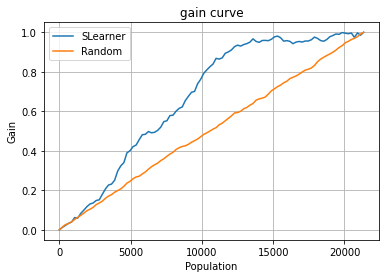

In [11]:
score_auuc = auuc_score(df_uplift, outcome=outcome, treatment=treatment, random_name=None)
print('score_auuc', score_auuc.values[0])

gain = get_gain(df_uplift, outcome=outcome, treatment=treatment, random_name='Random')
plot_gain(gain, normalize=True)
plt.title('gain curve')
plt.show()

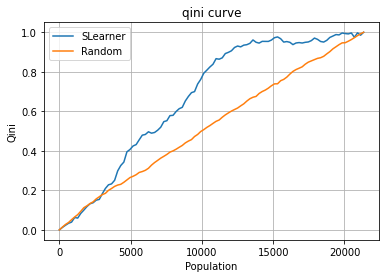

score_qini 0.17647570637715582


In [12]:
qini = get_qini(df_uplift, outcome=outcome, treatment=treatment, random_name='Random')
plot_qini(qini, normalize=True)
plt.title('qini curve')
plt.show()

score_qini = qini_score(df_uplift, outcome=outcome, treatment=treatment, random_name=None)
print('score_qini', score_qini.values[0])


## Uplift with TLearner, XLearner

In [13]:
def uplift(learner, train_data,test_data, learner_name):
    learner.fit(
        data=train_data,
        outcome=outcome,
        treatment=treatment,
        covariate=covariate
    )

    s_pred = learner.estimate(data=test_data, target_outcome=1)
    df_uplift = pd.DataFrame()
    df_uplift[learner_name] = list(s_pred)
    df_uplift[treatment] = test_data[treatment].values
    df_uplift[outcome] = test_data[outcome].values
    
    
    score_auuc = auuc_score(df_uplift, outcome=outcome, treatment=treatment, random_name=None)
    print('score_auuc', score_auuc.values[0])

    gain = get_gain(df_uplift, outcome=outcome, treatment=treatment, random_name='Random')
    print(gain.head(10))
    plot_gain(gain, normalize=True)
    plt.title('gain curve')
    plt.show()
    
    qini = get_qini(df_uplift, outcome=outcome, treatment=treatment, random_name='Random')
    print(qini.head(10))
    plot_qini(qini, normalize=True)
    plt.title('qini curve')
    plt.show()

    score_qini = qini_score(df_uplift, outcome=outcome, treatment=treatment, random_name=None)
    print('score_qini', score_qini.values[0])


[11:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score_auuc 0.5958390914694983
   TLearner    Random
0  0.000000  0.000000
1  0.001086  0.000272
2  0.002172  0.000543
3  0.003259  0.000163
4  0.002172  0.000217
5  0.002716  0.000091
6  0.003259  0.000054
7  0.002534  0.000127
8  0.004345  0.000116
9  0.003910  0.000114


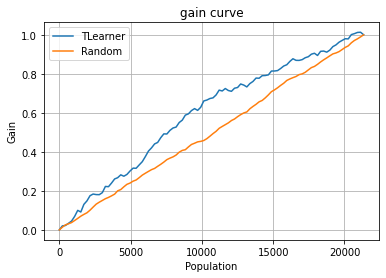

   TLearner    Random
0  0.000000  0.000000
1  0.000000  0.000000
2  0.002162  0.000000
3  0.002162  0.000216
4  0.002162  0.000577
5  0.002162  0.000937
6  0.002162  0.000757
7  0.002162  0.000595
8  0.004325  0.000605
9  0.004325  0.000519


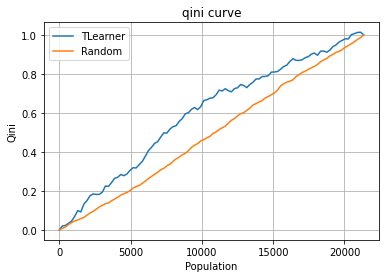

score_qini 0.10015663196335195


In [14]:
xgb = xgboost.XGBClassifier(n_estimators=100,
                            max_depth=5,
                            min_child_weight=5,
                            learning_rate=0.1,
                            gamma=1,
                            reg_alpha=1,
                            reg_lambda=1,
                            random_state=2022)
tlearner = TLearner(model=xgb, is_discrete_outcome=True, proba_output=True)
uplift(tlearner,train_data_bogo, test_data_bogo, 'TLearner')

[11:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:31:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score_auuc 0.7127533228963414
   XLearner    Random
0  0.000000  0.000000
1  0.000543  0.000036
2  0.001086  0.000072
3  0.001629  0.000109
4  0.001448  0.000362
5  0.001358  0.000679
6  0.001629  0.000728
7  0.001521  0.000824
8  0.001448  0.001190
9  0.001629  0.001303


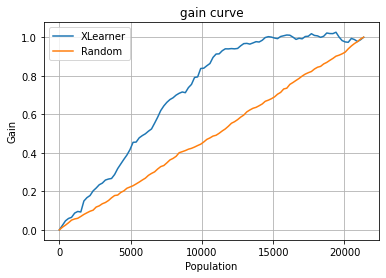

   XLearner    Random
0  0.000000  0.000000
1  0.000721 -0.000036
2  0.001442  0.000144
3  0.002162 -0.000108
4  0.002162  0.000000
5  0.002162 -0.000198
6  0.002162 -0.000476
7  0.002162  0.000040
8  0.002162  0.000360
9  0.002162  0.000303


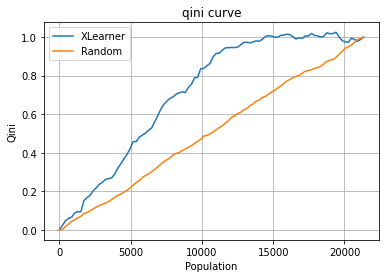

score_qini 0.2224549650075083


In [15]:
xgb = xgboost.XGBClassifier(n_estimators=100,
                            max_depth=5,
                            min_child_weight=5,
                            learning_rate=0.1,
                            gamma=1,
                            reg_alpha=1,
                            reg_lambda=1,
                            random_state=2022)
final_model = LinearRegression()
xlearner = XLearner(model=xgb, is_discrete_outcome=True, proba_output=True, final_proba_model=final_model)
uplift(xlearner,train_data_bogo, test_data_bogo, 'XLearner')